# Final position in variable interval


## Dependencies


The dependencies used are as follows


In [1]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import make_scorer

import sys

sys.path.append("..")

from utils.visualization import model_selection
from utils.custom_cvs import VariableTimeSeriesSplit
from utils.custom_scorers import balanced_accuracy_1interval_score

import pandas as pd

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

import warnings

warnings.simplefilter("ignore")

## Initialization


First we will do the tuning of the model that predicts the final position of each driver at a ±1 interval.


In [2]:
df = pd.read_csv("../assets/data/processed/base_model.csv")

mid_rc = df.groupby("raceYear")["raceRound"].max().to_numpy() // 2
get_half = lambda x: f'{x["raceYear"]}{x["raceRound"] <= mid_rc[x["raceYear"] - 2006]}'
instances_per_half = df.apply(get_half, axis=1).value_counts(sort=False).to_numpy()

n_splits = len(instances_per_half) - 10
max_train_size = [instances_per_half[i : 10 + i].sum() for i in range(n_splits)]
test_size = instances_per_half[10:].tolist()
tscv = VariableTimeSeriesSplit(
    n_splits=n_splits, max_train_size=max_train_size, test_size=test_size
)

X = pd.read_csv("../assets/data/processed/base_model_X.csv")
y = df["positionFinal"]

## K-Nearest Neighbors


PI: 0.316 with (0, 1, 6, 17, 18, 23) == ('carNumber', 'constructorNationality',
	'constructorWins', 'driverAgeAtRace', 'driverWins', 'positionGrid')
SFS: 0.347 with (1, 5, 17) == ('positionGrid', 'constructorRef', 'driverWins')
GA: 0.295 with (1, 2, 4, 5, 6, 7, 9, 10, 11, 13, 17, 18, 19) == ('positionGrid',
	'driverRef', 'driverNationality', 'constructorRef', 'constructorNationality',
	'raceYear', 'grandPrix', 'raceTime', 'circuitRef', 'circuitCountry', 'driverWins',
	'constructorWins', 'q1')


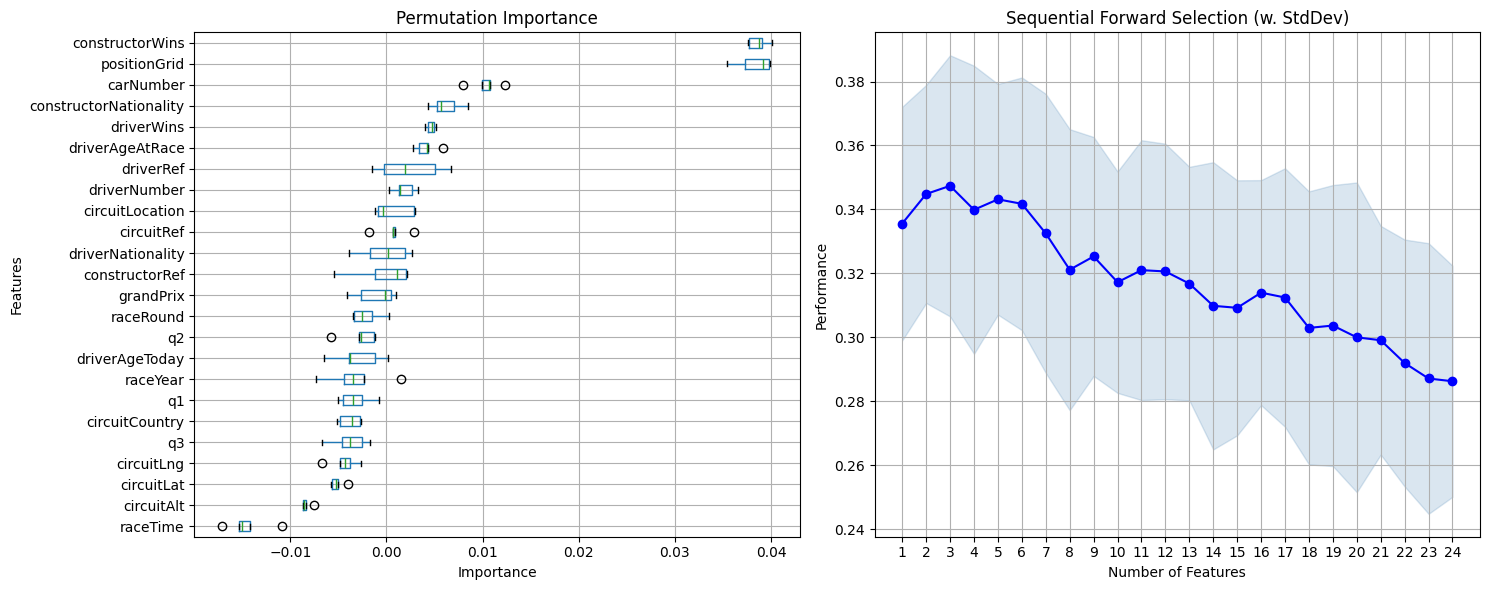

In [3]:
knn = KNeighborsClassifier(n_neighbors=101, metric="manhattan", weights="uniform")
scoring = make_scorer(balanced_accuracy_1interval_score)
model_selection(knn, X, y, tscv, scoring)

## Decision Tree


PI: 0.343 with (0, 1, 18) == ('carNumber', 'constructorWins', 'positionGrid')
SFS: 0.349 with (0, 1, 4, 6, 7, 8, 9, 10, 11, 12, 15, 16, 18, 19, 20, 21, 22) ==
	('carNumber', 'positionGrid', 'driverNationality', 'constructorNationality',
	'raceYear', 'raceRound', 'grandPrix', 'raceTime', 'circuitRef', 'circuitLocation',
	'circuitLng', 'circuitAlt', 'constructorWins', 'q1', 'q2', 'q3', 'driverAgeToday')
GA: 0.345 with (0, 1, 6, 8, 9, 10, 11, 12, 14, 16, 18, 23) == ('carNumber',
	'positionGrid', 'constructorNationality', 'raceRound', 'grandPrix', 'raceTime',
	'circuitRef', 'circuitLocation', 'circuitLat', 'circuitAlt', 'constructorWins',
	'driverAgeAtRace')


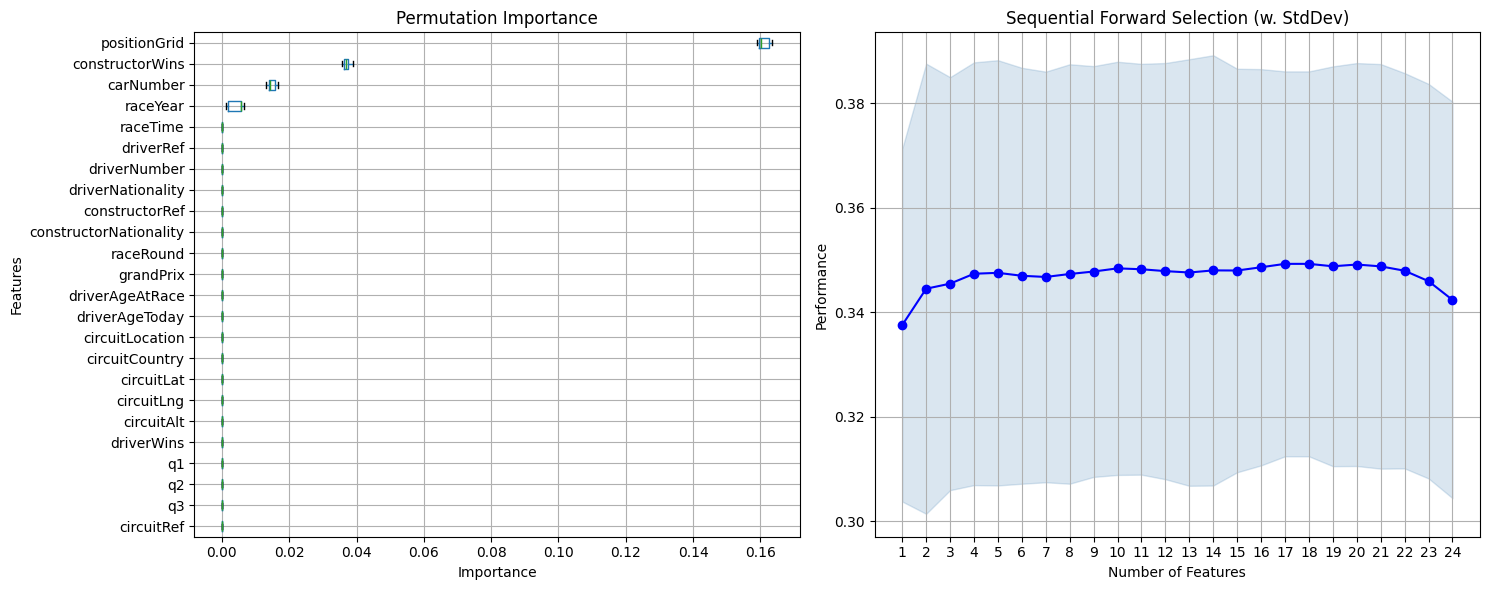

In [4]:
tree = DecisionTreeClassifier(criterion="entropy", max_depth=4, splitter="best")
scoring = make_scorer(balanced_accuracy_1interval_score)
model_selection(tree, X, y, tscv, scoring)

## Random Forest


PI: 0.351 with (0, 1, 2, 3, 5, 7, 8, 9, 11, 13, 16, 17, 18, 19, 20, 22, 23) ==
	('carNumber', 'circuitAlt', 'circuitCountry', 'circuitRef', 'constructorRef',
	'constructorWins', 'driverAgeAtRace', 'driverAgeToday', 'driverNumber', 'driverRef',
	'driverWins', 'grandPrix', 'positionGrid', 'q1', 'q2', 'raceRound', 'raceYear')
SFS: 0.365 with (0, 1, 2, 6, 8, 17) == ('carNumber', 'positionGrid', 'driverRef',
	'constructorNationality', 'raceRound', 'driverWins')
GA: 0.354 with (1, 3, 5, 6, 7, 8, 9, 12, 14, 17, 18, 19, 20, 21) == ('positionGrid',
	'driverNumber', 'constructorRef', 'constructorNationality', 'raceYear', 'raceRound',
	'grandPrix', 'circuitLocation', 'circuitLat', 'driverWins', 'constructorWins', 'q1',
	'q2', 'q3')


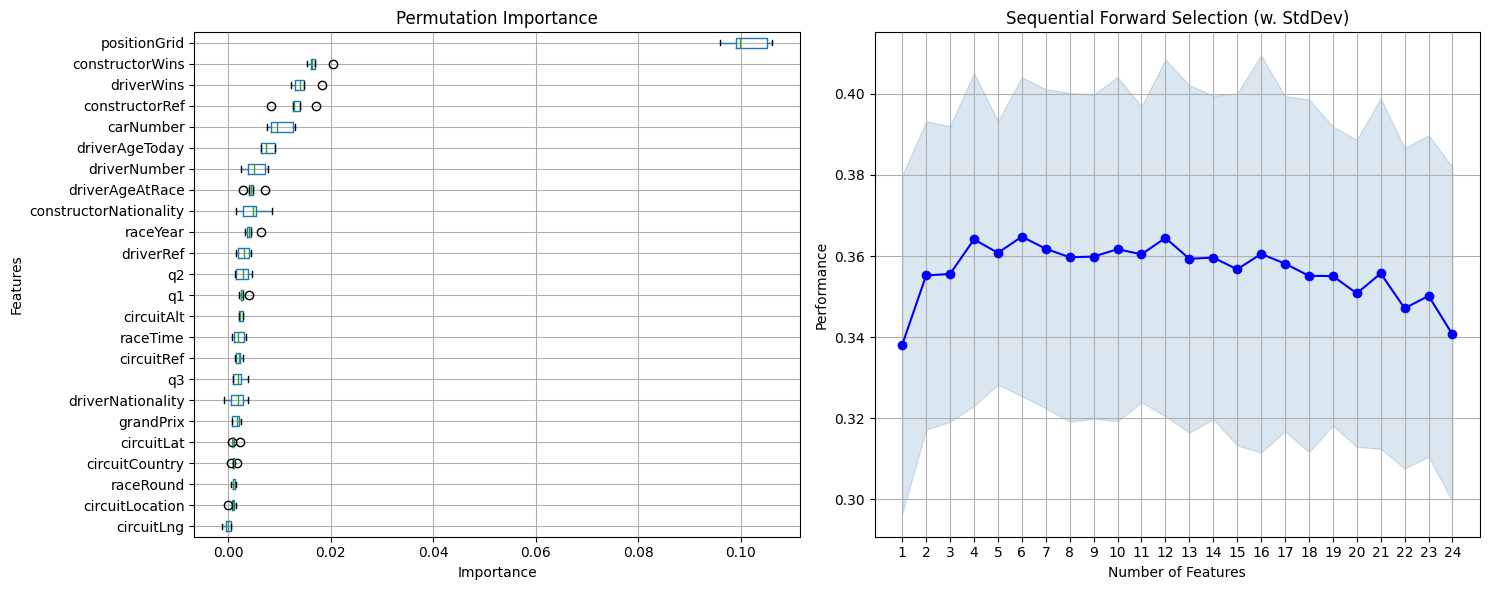

In [5]:
random_forest = RandomForestClassifier(criterion="gini", max_depth=5, n_estimators=200)
scoring = make_scorer(balanced_accuracy_1interval_score)
model_selection(random_forest, X, y, tscv, scoring)

## Multilayer Perceptron


PI: 0.352 with (0, 1, 4, 6, 7, 8, 10, 15, 17, 18, 21, 22) == ('carNumber', 'circuitLng',
	'constructorNationality', 'constructorWins', 'driverAgeToday', 'driverNationality',
	'driverWins', 'positionGrid', 'q3', 'raceRound', 'raceTime', 'raceYear')
SFS: 0.361 with (1, 2, 3, 5, 8, 13, 16, 17, 18, 22) == ('positionGrid', 'driverRef',
	'driverNumber', 'constructorRef', 'raceRound', 'circuitCountry', 'circuitAlt',
	'driverWins', 'constructorWins', 'driverAgeToday')
GA: 0.361 with (1, 4, 13, 15, 18, 19, 23) == ('positionGrid', 'driverNationality',
	'circuitCountry', 'circuitLng', 'constructorWins', 'q1', 'driverAgeAtRace')


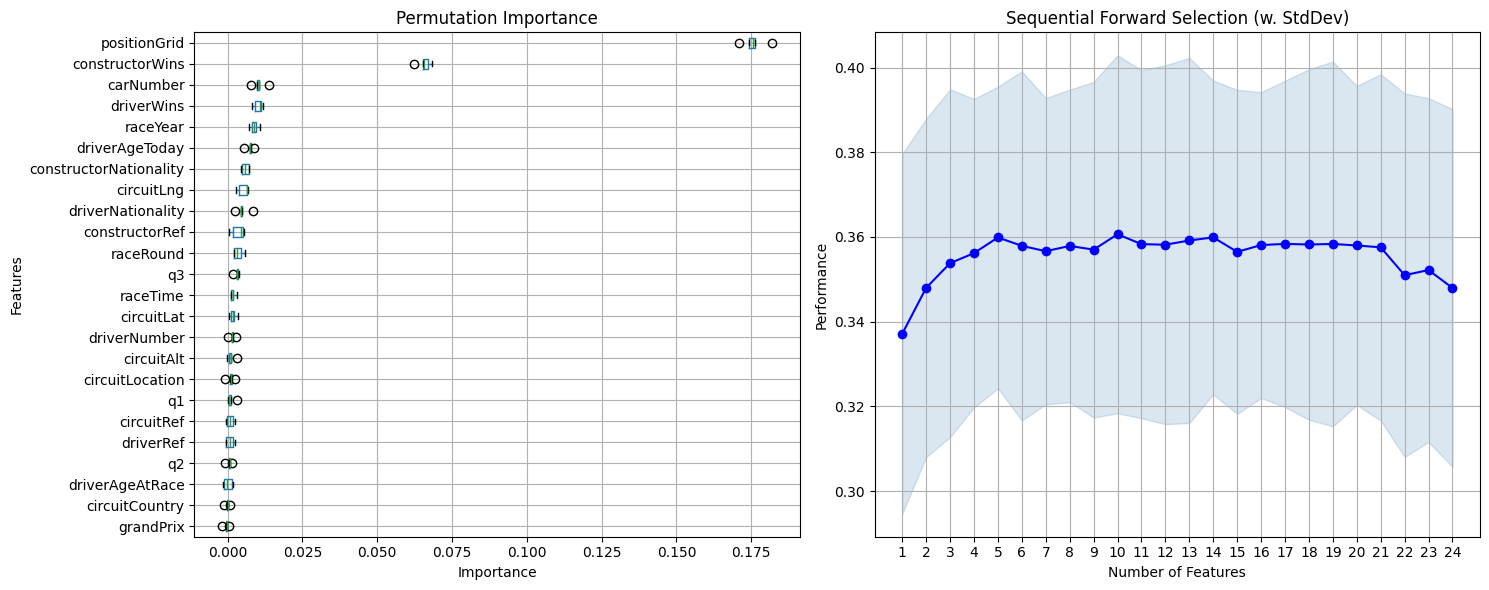

In [6]:
nn = MLPClassifier(activation="logistic", hidden_layer_sizes=(50, 25))
scoring = make_scorer(balanced_accuracy_1interval_score)
model_selection(nn, X, y, tscv, scoring)

## Results


Therefore, the selection for each algorithm are as follows

- KNeighborsClassifier: 0.347 with ('positionGrid', 'constructorRef', 'driverWins')
- DecisionTreeClassifier: 0.349 with ('carNumber', 'positionGrid', 'driverNationality', 'constructorNationality', 'raceYear', 'raceRound', 'grandPrix', 'raceTime', 'circuitRef', 'circuitLocation', 'circuitLng', 'circuitAlt', 'constructorWins', 'q1', 'q2', 'q3', 'driverAgeToday')
- RandomForestClassifier: 0.365 with ('carNumber', 'positionGrid', 'driverRef', 'constructorNationality', 'raceRound', 'driverWins')
- MLPClassifier: 0.361 with ('positionGrid', 'driverRef', 'driverNumber', 'constructorRef', 'raceRound', 'circuitCountry', 'circuitAlt', 'driverWins', 'constructorWins', 'driverAgeToday')
